# 线性回归

- 线性回归有显示解，而实际的神经网络是np复杂度
- 线性回归可以看做是单层神经网络

- 当前位置的梯度方向，为函数在该位置处方向导数最大的方向，也是函数值上升最快的方向，反方向为下降最快的方向，两个方向的方向导数模值相同
- 小批量随机梯度下降是深度学习默认求解算法
- 两个重要的超参数：批量大小、学习率

## 1. 线性回归从零实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + 噪声"""
    X = torch.normal(0, 1, size=(num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, size=y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.3957, -0.9979]) 
label: tensor([8.3861])


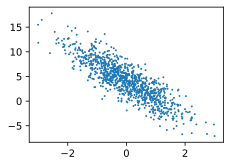

In [3]:
from matplotlib import pyplot as plt
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = indices[i : min(i + batch_size, num_examples)]
        yield features[indices], labels[indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5953,  0.9740],
        [ 1.0370,  1.0400],
        [-0.5946, -0.2898],
        ...,
        [ 0.7180,  1.5670],
        [ 0.7673,  0.5476],
        [-0.3607,  1.5084]]) 
 tensor([[ 2.0921e+00],
        [ 2.7393e+00],
        [ 3.9885e+00],
        [ 1.6172e+00],
        [ 1.0558e-01],
        [ 9.8735e+00],
        [ 5.7779e+00],
        [ 3.6728e-01],
        [ 5.2164e+00],
        [ 4.8852e+00],
        [ 5.5386e+00],
        [ 2.6099e+00],
        [ 5.2647e+00],
        [ 1.5480e+01],
        [ 6.2221e+00],
        [ 5.0439e+00],
        [ 1.2061e+01],
        [ 6.2634e+00],
        [ 3.9323e+00],
        [ 1.2746e+01],
        [ 4.4616e+00],
        [ 7.2514e+00],
        [ 2.8792e+00],
        [ 1.9803e+00],
        [ 5.7164e+00],
        [ 7.1891e+00],
        [ 4.7110e+00],
        [ 4.7734e+00],
        [ 4.4333e+00],
        [ 1.0069e+01],
        [ 6.5493e+00],
        [ 3.7084e+00],
        [-1.8895e+00],
        [-2.1340e+00],
        [ 1.1232e+01],
        [ 2

In [5]:
def linreg(X, w, b):
    """预测模型"""
    return torch.matmul(X, w) + b

In [6]:
def squared_loss(y_hat, y, batch_size):
    """损失函数：标量"""
    return ((y_hat - y) ** 2).sum() / (2 * batch_size)

In [7]:
def sgd(params, lr):
    with torch.no_grad():  # 梯度下降时不再记录梯度
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.001
epochs = 5
net = linreg
loss = squared_loss

for epoch in range(epochs):
    for X, y in data_iter(batch_size, features, labels):
        y_hat = net(X, w, b)
        l = loss(y_hat, y, batch_size)
        l.backward()
        sgd([w, b], lr)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels, batch_size)
        print(f'epoch{epoch + 1}: loss {float(train_l):f}')  # f’可以自定义format

epoch1: loss 0.004465
epoch2: loss 0.004463
epoch3: loss 0.004463
epoch4: loss 0.004463
epoch5: loss 0.004463


In [9]:
y_hat.shape, y.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [10]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')  # 如果shape不一样，会有广播机制！！
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0001, -0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)


## 2. 线性回归的简洁实现

In [11]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [12]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)  # data_arrays是X和y的元组，加*号代表可变入参，等同于TensorDataset(X, y)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))


[tensor([[ 0.1921,  1.1771],
         [-1.2303,  1.1618],
         [-0.1194, -1.7879],
         [-0.4841, -1.4657],
         [ 0.6664,  1.0522],
         [-0.0863,  0.7050],
         [ 1.1743,  0.0215],
         [ 0.4801, -1.1654],
         [-1.6368, -1.5167],
         [-0.1160, -0.4291]]),
 tensor([[ 0.5958],
         [-2.2088],
         [10.0415],
         [ 8.2154],
         [ 1.9538],
         [ 1.6316],
         [ 6.4727],
         [ 9.1142],
         [ 6.0860],
         [ 5.4306]])]

In [13]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))  # list of layers

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [14]:
loss = nn.MSELoss()  # 均方误差

trainer = torch.optim.SGD(net.parameters(), lr=0.03)
trainer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [15]:
num_epochs = 5
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch{epoch + 1}, loss {l:.8f}')

epoch1, loss 0.00026072
epoch2, loss 0.00009927
epoch3, loss 0.00009914
epoch4, loss 0.00009952
epoch5, loss 0.00009829
